# Plot regional maps with mean current ellipses on top


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

import xarray as xr

#plt.style.use('dark_background')

%matplotlib inline


## 1. Load and Prep. data

### 1.1 Load data into DataFrame

In [2]:
pathdir = '../data/raw/csv_ctdgrid'
file4 = pathdir+'/'+'EEL_LADCP_3Dfield.csv'
dflad = pd.read_csv(file4,sep=',', index_col=None, 
                     header=0)
dflad=dflad.round({'LADCP_U': 3, 'LADCP_V': 3})
dflad['Refdist']=dflad['Refdist'].apply(int)
dflad

,CruiseID,Year,Staname,Refdist,Depth,LADCP_U,LADCP_V
0,d22396,1996,13G,1191,25,-0.227,0.019
1,d22396,1996,13G,1191,35,-0.230,0.044
2,d22396,1996,13G,1191,45,-0.236,0.049
3,d22396,1996,13G,1191,55,-0.251,0.052
4,d22396,1996,13G,1191,65,-0.283,0.066
...,...,...,...,...,...,...,...
76029,dy078,2017,IB23S,0,65,0.026,0.078
76030,dy078,2017,IB23S,0,75,0.045,0.146
76031,dy078,2017,IB23S,0,85,0.036,0.166
76032,dy078,2017,IB23S,0,95,0.026,0.180


In [3]:
df3D = dflad.rename(columns={"Refdist": "refdist","Year": "year","Depth": "depth"}).set_index(['refdist','year','depth']).round(3).sort_values(['refdist','year','depth']).drop(columns=['CruiseID','Staname'])
df3D=df3D.rename(columns={"LADCP_U": "U", "LADCP_V": "V"})
df3D

U      V
refdist year depth              
0       2005 15    -0.122  0.196
             25    -0.118  0.191
             35    -0.108  0.180
             45    -0.104  0.169
             55    -0.110  0.174
...                   ...    ...
1242    2017 115    0.128  0.087
             125    0.165  0.092
             135    0.181  0.103
             145    0.186  0.120
             155    0.196  0.155

[76034 rows x 2 columns]

<br><br>
### 1.2 Convert 3D dataframe into DataSet

In [4]:
da0 = df3D.to_xarray()
print(da0)

<xarray.Dataset>
Dimensions:  (depth: 271, refdist: 60, year: 15)
Coordinates:
  * refdist  (refdist) int64 0 13 25 55 84 122 ... 1170 1180 1191 1222 1232 1242
  * year     (year) int64 1996 1997 1998 1999 2000 ... 2013 2014 2015 2016 2017
  * depth    (depth) int64 5 15 25 35 45 55 65 ... 2655 2665 2675 2685 2695 2705
Data variables:
    U        (refdist, year, depth) float64 nan nan nan nan ... nan nan nan nan
    V        (refdist, year, depth) float64 nan nan nan nan ... nan nan nan nan


<br><br>
### 1.3 Add additional Variables from metadatafile (Lat,Lon, Station Name, Cruise ID)

In [5]:
# Get position metadata
pathdir = '../data/raw/csv_ctdgrid'
dfloc = pd.read_csv(pathdir+'/'+'EELCTDandLADCP_refpos.csv',sep=',', index_col=None, 
                     header=0)
# Make sure the station name are sorted by their distance along the section
sdfloc = dfloc.rename(columns={"Refdist": "refdist"}).sort_values('refdist', ascending=True)
sdfloc['refdist']=sdfloc['refdist'].apply(int)
sdfloc=sdfloc.set_index('refdist')

daloc = sdfloc.to_xarray()
print(daloc)

<xarray.Dataset>
Dimensions:   (refdist: 69)
Coordinates:
  * refdist   (refdist) int64 0 13 25 55 84 122 ... 1277 1286 1292 1298 1307
Data variables:
    Staname   (refdist) object 'IB23S' 'IB22S' 'IB21S' ... '3G' '2G' '1G'
    LonSta    (refdist) float64 -20.21 -20.07 -19.92 ... -6.367 -6.283 -6.133
    LatSta    (refdist) float64 63.32 63.22 63.13 62.92 ... 56.71 56.68 56.67
    DepthSta  (refdist) int64 120 670 1030 1400 1670 1790 ... 80 115 70 30 190


In [6]:
# Get cruise (time) metadata
dfdate = pd.read_csv(pathdir+'/'+'EELCTDandLADCP_refdate.csv',sep=',', index_col=None, 
                     header=0).rename(columns={"Year": "year"}).set_index('year')
dadate = dfdate.to_xarray()
print(dadate)

<xarray.Dataset>
Dimensions:   (year: 17)
Coordinates:
  * year      (year) int64 1996 1997 1998 1999 2000 ... 2013 2014 2015 2016 2017
Data variables:
    CruiseID  (year) object 'd22396' 'd23097' 'd23398' ... 'dy052' 'dy078'
    Month     (year) int64 10 9 5 9 2 12 10 10 8 6 5 5 5 7 6 6 5


<br><br>
#### Merge metadata into main Dataset 

In [7]:
da=xr.merge([da0, daloc,dadate])
print(da)

<xarray.Dataset>
Dimensions:   (depth: 271, refdist: 69, year: 17)
Coordinates:
  * refdist   (refdist) int64 0 13 25 55 84 122 ... 1277 1286 1292 1298 1307
  * year      (year) int64 1996 1997 1998 1999 2000 ... 2013 2014 2015 2016 2017
  * depth     (depth) int64 5 15 25 35 45 55 ... 2655 2665 2675 2685 2695 2705
Data variables:
    U         (refdist, year, depth) float64 nan nan nan nan ... nan nan nan nan
    V         (refdist, year, depth) float64 nan nan nan nan ... nan nan nan nan
    Staname   (refdist) object 'IB23S' 'IB22S' 'IB21S' ... '3G' '2G' '1G'
    LonSta    (refdist) float64 -20.21 -20.07 -19.92 ... -6.367 -6.283 -6.133
    LatSta    (refdist) float64 63.32 63.22 63.13 62.92 ... 56.71 56.68 56.67
    DepthSta  (refdist) int64 120 670 1030 1400 1670 1790 ... 80 115 70 30 190
    CruiseID  (year) object 'd22396' 'd23097' 'd23398' ... 'dy052' 'dy078'
    Month     (year) int64 10 9 5 9 2 12 10 10 8 6 5 5 5 7 6 6 5


\
Move variables into coordinates

In [8]:
da.coords['lon'] = ('refdist', da.LonSta)
da.coords['lat'] = ('refdist', da.LatSta)
da.coords['Staname'] = ('refdist', da.Staname)
da = da.drop(['LonSta','LatSta'])
print(da)

<xarray.Dataset>
Dimensions:   (depth: 271, refdist: 69, year: 17)
Coordinates:
  * refdist   (refdist) int64 0 13 25 55 84 122 ... 1277 1286 1292 1298 1307
  * year      (year) int64 1996 1997 1998 1999 2000 ... 2013 2014 2015 2016 2017
  * depth     (depth) int64 5 15 25 35 45 55 ... 2655 2665 2675 2685 2695 2705
    Staname   (refdist) object 'IB23S' 'IB22S' 'IB21S' ... '3G' '2G' '1G'
    lon       (refdist) float64 -20.21 -20.07 -19.92 ... -6.367 -6.283 -6.133
    lat       (refdist) float64 63.32 63.22 63.13 62.92 ... 56.71 56.68 56.67
Data variables:
    U         (refdist, year, depth) float64 nan nan nan nan ... nan nan nan nan
    V         (refdist, year, depth) float64 nan nan nan nan ... nan nan nan nan
    DepthSta  (refdist) int64 120 670 1030 1400 1670 1790 ... 80 115 70 30 190
    CruiseID  (year) object 'd22396' 'd23097' 'd23398' ... 'dy052' 'dy078'
    Month     (year) int64 10 9 5 9 2 12 10 10 8 6 5 5 5 7 6 6 5


<br><br>
### 1.4 Visual inspection of the data

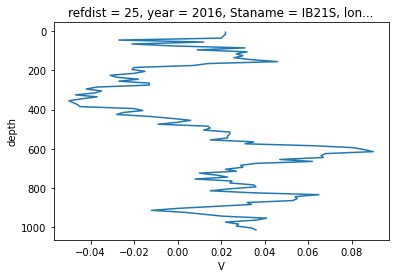

In [9]:
da.V[2,-2,:].plot(y='depth', yincrease=False)


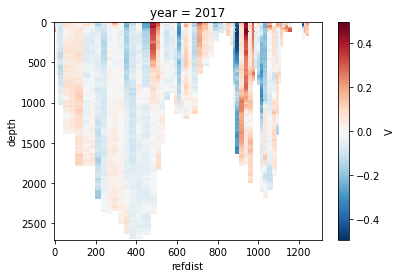

In [10]:
da.V.sel(year=2017).plot(y='depth', yincrease=False)

\
Plot evolution of Velocity profile at station E

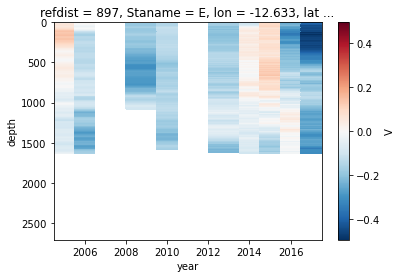

In [11]:
# Extra Refdist value associated with Station E
staE = da.refdist.values[da.Staname.values=='E'][0]

# Plot 
da.V.sel(refdist=staE,year=slice('2004','2017')).plot(y='depth', yincrease=False)

<br><br>
## 2. Plot Variance ellipse of Depth Average Current
### 2.1 Test for a specific station

/Users/locupe/anaconda2/envs/analysis_eel_data/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


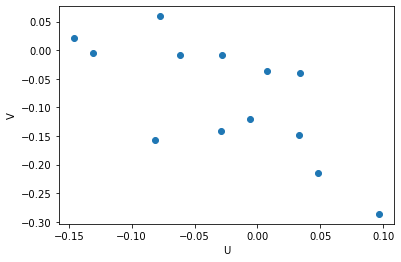

In [12]:
daMean=da.mean(dim='depth')
sc = daMean.sel(refdist=staE).plot.scatter(x='U',y='V')

\
Define the confidence_ellipse function (more info [here](https://matplotlib.org/3.2.1/gallery/statistics/confidence_ellipse.html#sphx-glr-gallery-statistics-confidence-ellipse-py) )

In [13]:
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    Returns
    -------
    matplotlib.patches.Ellipse

    Other parameters
    ----------------
    kwargs : `~matplotlib.patches.Patch` properties
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0),
        width=ell_radius_x * 2,
        height=ell_radius_y * 2,
        facecolor=facecolor,
        **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

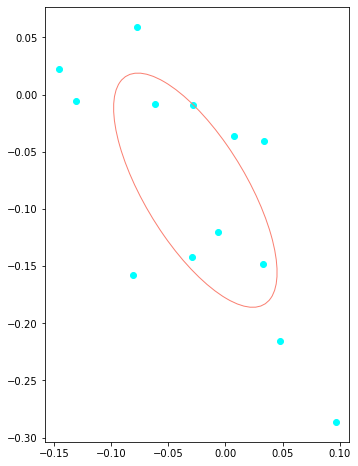

In [14]:
x = daMean.sel(refdist=staE).dropna('year').U.values
y = daMean.sel(refdist=staE).dropna('year').V.values


fig, ax = plt.subplots(figsize=(8, 8))
plt.scatter(x,y,color='cyan')

Qv = ax.quiver(0, 0, np.mean(x),  np.mean(y),
              angles='xy', scale_units='xy', scale=1,
              color='white')
plt.plot( np.mean(x), np.mean(y),'+',color='w')
confidence_ellipse(x, y, ax, n_std=1.0, edgecolor='salmon')

ax.set_aspect('equal', 'box')



In [15]:
np.mean(x)
np.mean(y)

-0.08364704878912728

<br><br>
#### TODO: plot distribution of depth average velocity at a specific station and compute the associated ellipse
Have a look to:
1. J. Lilly notes on variance ellipse http://jmlilly.net/course/v3/VarianceEllipsesDemo.html
2. Confidence ellipse function https://matplotlib.org/3.2.1/gallery/statistics/confidence_ellipse.html#sphx-glr-gallery-statistics-confidence-ellipse-py
3. How to draw patch using cartopy https://scitools.org.uk/cartopy/docs/v0.5/matplotlib/introductory_examples/02.polygon.html
